In [1]:
#!pip install pvlib
#!pip install --force-reinstall --no-deps git+https://github.com/isi-ies-group/cpvlib.git

In [2]:
import pandas as pd
import pvlib
import datetime
import matplotlib.pyplot as plt
import numpy as np
from cpvlib import cpvsystem

# Datos del módulo de vidrio solar

In [3]:
mod_params_vidrio = {
    'alpha_sc': 0.0008*8.93,#temp coef of Isc 0.007144
    'a_ref': 0.712,
    'I_L_ref': 8.994,
    'I_o_ref': 0.00000157,
    'R_s': 0.01,
    'R_sh_ref': 3000,
    'EgRef': 1.121,
}

system = {   
    'surface_tilt': 30,
    'surface_azimuth': 180,
}

# Datos del módulo híbrido de Insolight

In [4]:
mod_params_cpv = {
    "gamma_ref": 5.524,
    "mu_gamma": 0.003,
    "I_L_ref": 0.96*0.9,
    "I_o_ref": 1.7e-10,
    "R_sh_ref": 5226,
    "R_sh_0": 21000,
    "R_sh_exp": 5.50,
    "R_s": 0.01,
    "alpha_sc": 0.00,
    "EgRef": 3.91,
    "irrad_ref": 1000,
    "temp_ref": 25,
    "cells_in_series": 12,
    "eta_m": 0.32,
    "alpha_absorption": 0.9,
    "b": 0.7,
    "iam_model": 'ashrae',
    "theta_ref": [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
    "iam_ref": [1.000, 1.007, 0.998, 0.991, 0.971, 0.966, 0.938, 0.894, 0.830, 0.790, 0.740, 0.649, 0.387],
}

UF_parameters_cpv = {
    "IscDNI_top": 0.96 / 1000,
    "am_thld": 4.574231933073185,
    "am_uf_m_low": 3.906372068620377e-06,
    "am_uf_m_high": -3.0335768119184845e-05,
    "ta_thld": 50,
    "ta_uf_m_low": 4.6781224141650075e-06,
    "ta_uf_m_high": 0,
    "weight_am": 0.2,
    "weight_temp": 0.8,
}

mod_params_cpv.update(UF_parameters_cpv)

# example (NO Insolight) PV module from:
# https://pvpmc.sandia.gov/PVLIB_Matlab_Help/html/pvl_calcparams_PVsyst_help.html
mod_params_flatplate = {
    "gamma_ref": 1.1,
    "mu_gamma": -0.0003,
    "I_L_ref": 8,
    "I_o_ref": 2.2e-9,
    "R_sh_ref": 200,
    "R_sh_0": 8700,
    "R_sh_exp": 5.5,
    "R_s": 0.33,
    "alpha_sc": -0.002,
    "EgRef": 1.121,
    "irrad_ref": 1000,
    "temp_ref": 25,
    "cells_in_series": 4, # 60,
    "eta_m": 0.95,  # pvsyst_celltemp() default value
    "alpha_absorption": 0.97,  # pvsyst_celltemp() default value
    "aoi_limit": 55,
}

# Obtención de datos solares

In [5]:
lat, lon, alt, tz = 40.4, -3.7, 695, 'utc'
location = pvlib.location.Location(latitude=lat, 
                                   longitude=lon, 
                                   altitude=alt, 
                                   tz=tz)

data_pvgis = pvlib.iotools.get_pvgis_tmy(lat, lon)
data = data_pvgis[0].rename(columns={
    'Gb(n)': 'dni',
    'G(h)': 'ghi',
    'Gd(h)': 'dhi',
    'T2m': 'temp_air',
    'WS10m': 'wind_speed',
})

#data.index = pd.to_datetime(data.index)
#data = data.sort_index()
#data1 = data['2010']  #Seleccionar un año completo
#data2 = data['2010-04']  #Seleccionar un mes completo
#data3 = data['2010-07-01':'2010-07-05']  #Seleccionar periodo entre fechas

dataX = data.set_index(
    data.index.map(lambda t: t.replace(year=2010)))


data0 = dataX  #Usado para las gráficas:

solar_zenith = location.get_solarposition(data0.index).zenith
solar_azimuth = location.get_solarposition(data0.index).azimuth

In [6]:
dii = pvlib.irradiance.beam_component(system['surface_tilt'],
                                      system['surface_azimuth'],
                                      solar_zenith,
                                      solar_azimuth,
                                      dni=data0['dni'])

aoi = pvlib.irradiance.aoi(system['surface_tilt'], 
                           system['surface_azimuth'],
                           solar_zenith,
                           solar_azimuth)

poa_sky=pvlib.irradiance.get_sky_diffuse(system['surface_tilt'],
                                         system['surface_azimuth'],
                                         solar_zenith, 
                                         solar_azimuth, 
                                         ghi=data0['ghi'],
                                         dhi=data0['dhi'],
                                         dni=data0['dni'],
                                         dni_extra=None, 
                                         airmass=None, 
                                         model='isotropic', 
                                         model_perez='allsitescomposite1990')

poa_ground=pvlib.irradiance.get_ground_diffuse(system['surface_tilt'], 
                                               ghi=data0['ghi'], 
                                               albedo=0.25, 
                                               surface_type=None)

poa_irrad=pvlib.irradiance.poa_components(aoi=aoi, 
                                          dni=data0['dni'], 
                                          poa_sky_diffuse=poa_sky, 
                                          poa_ground_diffuse=poa_ground)

effectiveIrradiance = poa_irrad.poa_direct * np.absolute(np.cos(aoi)) * pvlib.iam.ashrae(aoi) + poa_irrad.poa_diffuse


# Cálculos para el vídrio solar

In [7]:
tempcell=pvlib.temperature.pvsyst_cell(poa_irrad.poa_global, 
                                       data0['temp_air'], 
                                       data0['wind_speed'])

IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
    effective_irradiance=effectiveIrradiance,
    temp_cell=tempcell,
    alpha_sc=mod_params_vidrio['alpha_sc'],
    a_ref=mod_params_vidrio['a_ref'],
    I_L_ref=mod_params_vidrio['I_L_ref'],
    I_o_ref=mod_params_vidrio['I_o_ref'],
    R_sh_ref=mod_params_vidrio['R_sh_ref'],
    R_s=mod_params_vidrio['R_s'],
    EgRef=mod_params_vidrio['EgRef'],
)

dc_pv = pvlib.pvsystem.singlediode(
    photocurrent=IL,
    saturation_current=I0,
    resistance_series=Rs,
    resistance_shunt=Rsh,
    nNsVth=nNsVth,
    ivcurve_pnts=100,
    method='lambertw'
)

# Cálculos para el módulo híbrido de Insolight

In [8]:
static_hybrid_sys = cpvsystem.StaticHybridSystem(
    surface_tilt=system['surface_tilt'],
    surface_azimuth=system['surface_azimuth'],
    module_cpv=None,
    module_flatplate=None,
    module_parameters_cpv=mod_params_cpv,
    module_parameters_flatplate=mod_params_flatplate,
    modules_per_string=1,
    strings_per_inverter=1,
    inverter=None,
    inverter_parameters=None,
    racking_model="insulated",
    losses_parameters=None,
    name=None,
)

dii_effective, poa_flatplate_static_effective = static_hybrid_sys.get_effective_irradiance(
    solar_zenith,
    solar_azimuth,
    #iam_param=0.7,
    #aoi_limit=55,
    dii=None,
    ghi=data0['ghi'],
    dhi=data0['dhi'],
    dni=data0['dni']
)


temp_cell_35, temp_cell_flatplate = static_hybrid_sys.pvsyst_celltemp(
    dii=dii_effective,
    poa_flatplate_static=poa_flatplate_static_effective,
    temp_air=data0['temp_air'],
    wind_speed=data0['wind_speed']
)

diode_parameters_cpv, diode_parameters_flatplate = static_hybrid_sys.calcparams_pvsyst(
    dii=dii_effective,
    poa_flatplate_static=poa_flatplate_static_effective,
    temp_cell_cpv=temp_cell_35,
    temp_cell_flatplate=temp_cell_flatplate,
)

dc_cpv, dc_flatplate = static_hybrid_sys.singlediode(
    diode_parameters_cpv, diode_parameters_flatplate)

airmass_absolute = location.get_airmass(data0.index).airmass_absolute

uf_cpv = static_hybrid_sys.get_global_utilization_factor_cpv(airmass_absolute, data0['temp_air'])

# Cálculos energéticos

In [9]:
energy_vidrio = dc_pv['p_mp'].sum()
print(f"E_Vidrio={energy_vidrio:.0f} Wh")

energy_cpv = (dc_cpv['p_mp'] * uf_cpv).sum()
energy_flatplate = dc_flatplate['p_mp'].sum()
print(f"E_CPV={energy_cpv:.0f} Wh", f"E_diff={energy_flatplate:.0f} Wh")

total_insolight = energy_cpv+energy_flatplate
print(f"Total Insolight={total_insolight:.0f} Wh")

E_Vidrio=92292 Wh
E_CPV=25758 Wh E_diff=8833 Wh
Total Insolight=34592 Wh


### Observamos que la generación calculada del vidrio solar resulta muy superior a la de Insolight, casi 3 veces mayor, por lo que debe haber algún error en los cálculos.

# Comprobación de datos

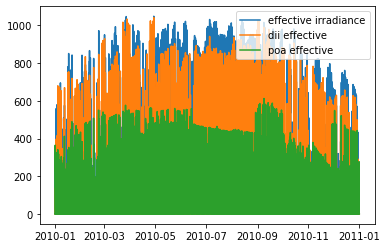

In [10]:
plt.plot(effectiveIrradiance, label='effective irradiance')
plt.plot(dii_effective, label='dii effective')
plt.plot(poa_flatplate_static_effective, label='poa effective')
plt.legend()
plt.show()

In [11]:
data0

,temp_air,RH,ghi,dni,dhi,IR(h),wind_speed,WD10m,SP
time(UTC),,,,,,,,,
2010-01-01 00:00:00+00:00,5.72,99.18,0.0,0.0,0.0,311.93,1.08,148.0,95127.0
2010-01-01 01:00:00+00:00,5.64,99.11,0.0,0.0,0.0,310.34,1.02,156.0,95124.0
2010-01-01 02:00:00+00:00,5.56,99.05,0.0,0.0,0.0,308.75,0.95,165.0,95121.0
2010-01-01 03:00:00+00:00,5.48,98.98,0.0,0.0,0.0,307.16,0.88,205.0,95117.0
2010-01-01 04:00:00+00:00,5.40,98.92,0.0,0.0,0.0,305.57,0.81,246.0,95114.0
...,...,...,...,...,...,...,...,...,...
2010-12-31 19:00:00+00:00,6.11,99.50,0.0,0.0,0.0,319.88,1.43,132.0,94857.0
2010-12-31 20:00:00+00:00,6.03,99.43,0.0,0.0,0.0,318.29,1.36,127.0,94897.0
2010-12-31 21:00:00+00:00,5.95,99.37,0.0,0.0,0.0,316.70,1.29,127.0,94910.0


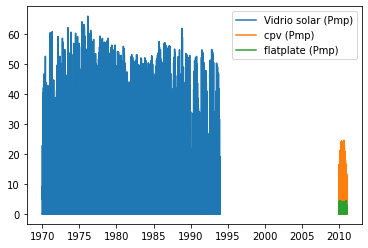

In [12]:
plt.plot(dc_pv['p_mp'], label='Vidrio solar (Pmp)')
plt.plot((dc_cpv['p_mp'] * uf_cpv), label='cpv (Pmp)')
plt.plot(dc_flatplate['p_mp'], label='flatplate (Pmp)')
plt.legend()
plt.show()

In [13]:
len(dc_pv['p_mp'])


8760

In [14]:
dc_pv['p_mp']

array([ 0., -0., -0., ...,  0., -0.,  0.])

In [15]:
len(dc_cpv['p_mp'])

8760

In [16]:
dc_cpv['p_mp']

time(UTC)
2010-01-01 00:00:00+00:00    0.000000e+00
2010-01-01 01:00:00+00:00   -0.000000e+00
2010-01-01 02:00:00+00:00    1.095978e-49
2010-01-01 03:00:00+00:00    1.095978e-49
2010-01-01 04:00:00+00:00    0.000000e+00
                                 ...     
2010-12-31 19:00:00+00:00    1.095978e-49
2010-12-31 20:00:00+00:00    1.095978e-49
2010-12-31 21:00:00+00:00    0.000000e+00
2010-12-31 22:00:00+00:00    0.000000e+00
2010-12-31 23:00:00+00:00   -0.000000e+00
Name: p_mp, Length: 8760, dtype: float64

### Observamos que los valores de potencia tienen un formato diferente, los correspondientes al módulo de concentración tienen forma de tabla, con la fecha como índice, y los del vidrio solar, de array. 

### Se ha comprobado la longitud de columna y del array y ambos presentan 8760 valores, uno por cada hora durante el año. Al hacer ".sum", no debería haber problema con los diferentes formatos, pero no se me ocurre donde más puede residir el error, ya que esta potencia es calculada directamente con la funcion de PVlib "singlediode".
